In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==1.15
!pip install keras==2.2.5
!pip install git+https://www.github.com/keras-team/keras-contrib.git

     |████████████████████████████████| 412.3MB 32kB/s 
     |████████████████████████████████| 3.8MB 27.3MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 512kB 38.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=8a2347dd24601281e877a35a693783976c882576d30129c63c5b9e72029e434b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tens

In [ ]:
import numpy as np

In [ ]:
char_encode = np.loadtxt('/content/drive/MyDrive/fast_text/3 address/train/char_encode.txt')
print(char_encode.shape)
char_encode = char_encode.reshape(int(char_encode.shape[0]/42), 42, char_encode.shape[1])
print(char_encode.shape)

(129192, 32)
(3076, 42, 32)


In [ ]:
# chuyển từ char encode sang char embedding
LEN_OF_VOCAB = 137
shape = char_encode.shape
char_embedd = np.zeros([shape[0],shape[1],shape[2],LEN_OF_VOCAB])
for i in range(shape[0]):
  for j in range(shape[1]):
    for k in range(shape[2]):
      char_int = char_encode[i,j,k]
      char_int = char_int.astype(np.int64)
      onehot = np.zeros(LEN_OF_VOCAB)
      onehot[char_int] = 1
      char_embedd[i,j,k,:] = onehot

print(char_embedd.shape)

(3076, 42, 32, 137)


In [ ]:
tag = np.loadtxt('/content/drive/MyDrive/fast_text/3 address/train/tag_train.txt')
tag = tag.reshape(int(tag.shape[0]/42), 42, tag.shape[1])
print(tag.shape)

(3076, 42, 14)


In [ ]:
word = np.loadtxt('/content/drive/MyDrive/fast_text/3 address/train/word_train.txt')
word = word.reshape(int(word.shape[0]/42), 42, word.shape[1])
print(word.shape)

(3076, 42, 300)


In [ ]:
from keras.models import Sequential, Model, Input
from keras.layers import LSTM, Dense, TimeDistributed, Activation, Bidirectional, Masking, Embedding, Dropout, Flatten, concatenate, Conv1D, MaxPool1D, Lambda, Softmax
from keras import backend as K
from keras_contrib.layers import CRF
from keras.utils import plot_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras_contrib.losses import  crf_loss
from keras_contrib.metrics import crf_accuracy

Using TensorFlow backend.


In [ ]:
num_word = 42
num_char = 32
num_char_of_a_sen = num_word * num_char
char_embedding_dim = 137
batch_size = 64
output_lenght = 14
#===========================================================================================
char_input  = Input(shape=(num_word, num_char, char_embedding_dim), name="char_input")
char        = TimeDistributed(  Conv1D(filters = 8, kernel_size = 3, padding='same') ) (char_input)
char        = TimeDistributed(  Conv1D(filters = 8, kernel_size = 3, padding='same') ) (char)
char        = TimeDistributed(  MaxPool1D(pool_size = 2)  )  (char)
char        = TimeDistributed(  Conv1D(filters = 16, kernel_size = 3, padding='same') ) (char)
char        = TimeDistributed(  Conv1D(filters = 16, kernel_size = 3, padding='same') ) (char)
char        = TimeDistributed(  MaxPool1D(pool_size = 2)  )  (char)
char_out    = TimeDistributed(  Flatten()   )   (char)
#============================================================================================
word_input  = Input(shape=(num_word, 300), name="word_input")
word_out    = word_input
#============================================================================================
concatenated = concatenate([char_out, word_out])
# main BiLSTM model==========================================================================
out     = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(concatenated)
out     = TimeDistributed(Dense(output_lenght))(out)
output  = Activation('softmax')(out)
# crf = CRF(14, name="output")
# output = crf(out)
#===========================================================================================
m = Model(inputs=[char_input, word_input], outputs=output)
plot_model(m, "/content/drive/MyDrive/model/img/model_.png", show_shapes=True)
m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# m.compile(optimizer='adam', loss=crf.loss_function, metrics=[crf.accuracy, f1_m])
m.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 42, 32, 137)  0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 42, 32, 8)    3296        char_input[0][0]                 
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 42, 32, 8)    200         time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 42, 16, 8)    0           time

In [ ]:
import keras

cp_callback = keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/CPoint model/mdl-last-1.h5', verbose=1, save_best_only=True)
es_callback = keras.callbacks.EarlyStopping(monitor='acc', patience=5)

character_train, character_test, word_train, word_test, tag_train, tag_test = train_test_split(char_embedd,word,tag, test_size=0.125)

# Train the model with the new callback
history = m.fit([character_train, word_train], tag_train,  
          epochs=100,
          batch_size = 64,
          validation_data=([character_test, word_test], tag_test),
          callbacks=[cp_callback,es_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2691 samples, validate on 385 samples
Epoch 1/100





2691/2691 [==============================] - 31s 12ms/step - loss: 1.1282 - acc: 0.7317 - val_loss: 0.5447 - val_acc: 0.8322

Epoch 00001: val_loss improved from inf to 0.54466, saving model to /content/drive/MyDrive/CPoint model/mdl-last-1.h5
Epoch 2/100
2691/2691 [==============================] - 27s 10ms/step - loss: 0.3683 - acc: 0.8693 - val_loss: 0.1795 - val_acc: 0.9684

Epoch 00002: val_loss improved from 0.54466 to 0.17955, saving model to /content/drive/MyDrive/CPoint model/mdl-last-1.h5
Epoch 3/100
2691/2691 [==============================] - 27s 10ms/step - loss: 0.1183 - acc: 0.9751 - val_loss: 0.0602 - val_acc: 0.9837

Epoch 00003: val_loss improved from 0.17955 to 0.06017, saving model to /content/drive/MyDrive/CPoint model/mdl-last-1.h5
Epoch 4/100
2691/2691 [==============================] - 27s 10ms/step - lo

In [ ]:
m.save("/content/drive/MyDrive/model/model-1.h5")

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


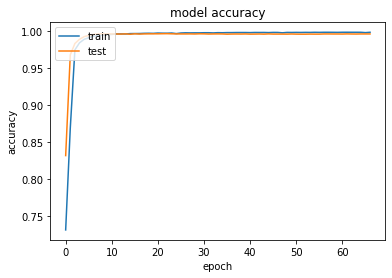

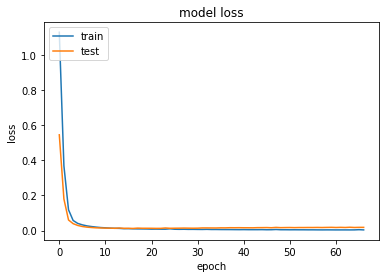

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# from keras.models import load_model
# dependencies = {
#     'recall_m': recall_m,
#     'precision_m':precision_m,
#     'f1_m':f1_m
# }
# custom_objects=dependencies
# m = load_model("/content/drive/MyDrive/CPoint model/mdl-last_only_address.h5",custom_objects=dependencies)
# m = load_model("/content/drive/MyDrive/CPoint model/mdl-last.h5")






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [ ]:
# y_pred = m.predict([character_test, word_test])
# y_true = tag_test

In [ ]:
# print(y_pred.shape)
# print(y_true.shape)

(600, 42, 14)
(600, 42, 14)


In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# y_pred = y_pred.reshape(y_pred.shape[0]*y_pred.shape[1], y_pred.shape[2])
# print(y_pred.shape)
# y_pred = np.argmax(y_pred,axis=1)

(25200, 14)


In [ ]:
# y_true = y_true.reshape(y_true.shape[0]*y_true.shape[1], y_true.shape[2])
# print(y_true.shape)
# y_true = np.argmax(y_true,axis=1)
# print(y_true.shape)

(25200, 14)


In [ ]:
# from sklearn.metrics import accuracy_score
# acc=0
# false=0
# for i in range(len(y_true)):
#   if y_true[i]!=0:
#     if y_true[i]==y_pred[i]:
#       acc+=1
#     else:
#       false+=1
# print(acc)
# print(false)
# print('accuracy = {}'.format(acc/(acc+false)) )

6331
35
accuracy = 0.9945020420986491


In [ ]:
# dict = []
# for element in y_true:
#   if element not in dict:
#     dict.append(element)
# print(dict)

[1, 2, 3, 4, 5, 6, 7, 0]


In [ ]:
# cnf_matrix = confusion_matrix(y_true, y_pred, labels=dict)
# for i in range(len(cnf_matrix)):
#   for j in range(len(cnf_matrix)):
#     cnf_matrix[i][j] = round(cnf_matrix[i][j], 3)
# print(cnf_matrix)

[[  703    24     0     0     0     0     0     0]
 [   11  2211     0     0     0     0     0     0]
 [    0     0  1017     0     0     0     0     0]
 [    0     0     0   600     0     0     0     0]
 [    0     0     0     0   600     0     0     0]
 [    0     0     0     0     0   600     0     0]
 [    0     0     0     0     0     0   600     0]
 [    0     0     0     0     0     0     0 18834]]


In [ ]:
# normalized_confusion_matrix = cnf_matrix/cnf_matrix.sum(axis = 1, keepdims = True)
# for i in range(len(normalized_confusion_matrix)):
#   for j in range(len(normalized_confusion_matrix)):
#     normalized_confusion_matrix[i][j] = round(normalized_confusion_matrix[i][j], 3)
# print(normalized_confusion_matrix)

[[0.967 0.033 0.    0.    0.    0.    0.    0.   ]
 [0.005 0.995 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]]


In [ ]:
# arr_to_cal_predict = []
# for i in range(len(cnf_matrix)):
#   tong= 0
#   for j in range(len(cnf_matrix)):
#     tong+=cnf_matrix[j][i]
#   arr_to_cal_predict.append(tong)
# print(arr_to_cal_predict)
# # lấy độ predict
# predict = []
# for i in range(len(cnf_matrix)):
#   tong=cnf_matrix[i][i]/arr_to_cal_predict[i]
#   predict.append(tong)
# print(predict)

[714, 2235, 1017, 600, 600, 600, 600, 18834]
[0.9845938375350141, 0.9892617449664429, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
